# Network inference under noisy channels

Under noiseless hardware, it seems that covariance methods reign supreme over entropic quantities by both computational complexity and performance. We hope to find regimes for which studying entropic quantities are advantageous. 

The intuition for examining noisy quantum channels is as follows. Covariance is a linear operator. It captures the linear relationship between two random variables. Mutual information also quantifies the amount of correlation between random quantities, but it assumes no linearity. Thus, I suspect when the linear formalism of quantum mechanics break down, the performance of covariance-based inference will decline, and perhaps more so than entropy-based methods.

In [1]:
import qnetti
import pennylane as qml
from pennylane import numpy as qnp
import qnetvo
import matplotlib.pyplot as plt
from functools import reduce
import json
from datetime import datetime

print(qnetvo.__version__)
print(qml.__version__)

0.4.1
0.28.0


In [15]:
qnp.random.seed(100)


def characteristic_matrix_inference(prep_node, num_steps, step_size):
    vn_opt_kwargs = {"num_steps": num_steps, "step_size": step_size}
    mi_opt_kwargs = {"num_steps": num_steps, "step_size": step_size}
    dev_kwargs = {"name": "default.mixed"}
    char_mat, mi_opt_dict, vn_opt_dict = qnetti.optimize_characteristic_matrix(
        prep_node, vn_opt_kwargs=vn_opt_kwargs, mi_opt_kwargs=mi_opt_kwargs, dev_kwargs=dev_kwargs
    )
    return char_mat.tolist()


def covariance_matrix_inference(prep_node, num_steps, step_size):
    cov_mat, opt_dict = qnetti.optimize_covariance_matrix(
        prep_node, step_size=step_size, num_steps=num_steps, dev_kwargs={"name": "default.mixed"}
    )
    return cov_mat.tolist()

In [10]:
def save_results(gamma, char_mat_data, cov_mat_data, exp_name):
    char_mat_data = [[mat for mat in mat_list] for mat_list in char_mat_data]
    cov_mat_data = [[mat for mat in mat_list] for mat_list in cov_mat_data]

    data = {"gamma": gamma, "char_mat_data": char_mat_data, "cov_mat_data": cov_mat_data}

    with open(
        "../data/" + exp_name + "_" + str(datetime.today().isoformat()) + ".json", "w"
    ) as outfile:
        json.dump(data, outfile)

In [11]:
def plot_result(shots_list, char_mat_data, cov_mat_data, idx_1=0, idx_2=1):
    char_mat_data = [[qnp.array(mat) for mat in mat_list] for mat_list in char_mat_data]
    cov_mat_data = [[qnp.array(mat) for mat in mat_list] for mat_list in cov_mat_data]
    plt.plot(
        shots_list,
        [reduce(lambda x, y: x + y, mat)[idx_1, idx_2] / trial for mat in char_mat_data],
        label="avg mutual information (bits)",
        color="#1f77b4",
        linestyle="dashed",
    )
    plt.plot(
        shots_list,
        [
            reduce(lambda x, y: qnp.abs(x) + qnp.abs(y), mat)[idx_1, idx_2] / trial
            for mat in cov_mat_data
        ],
        label="avg covariance",
        color="#ff7f0e",
        linestyle="dashed",
    )
    plt.plot(
        shots_list,
        [reduce(lambda x, y: qnp.maximum(x, y), mat)[idx_1, idx_2] for mat in char_mat_data],
        label="max mutual information (bits)",
        color="#1f77b4",
    )
    plt.plot(
        shots_list,
        [
            reduce(lambda x, y: qnp.maximum(qnp.abs(x), qnp.abs(y)), mat)[idx_1, idx_2]
            for mat in cov_mat_data
        ],
        label="max covariance",
        color="#ff7f0e",
    )
    plt.xlabel("number of shots")
    plt.ylabel("numerical value")

## Theoretical Values for Measured Mutual Information and Covariance

We will calculate the theoretical values for both mutual information and covariance for the purposes of verifying the optimization results. Each function takes in 1) the state (density matrix) prepared by the network $\rho$, and 2) the Kraus operators of the quantum channel $\{K_i\}$ (often parameterized by a noise parameter $\gamma \in [0,1]$) such that $\mathcal E(\rho) = \sum_i K_i \rho K_i^\dagger$.

**Note: this is probably not needed upon tweaking qnetti source code. But, I'll write this quick implementation to avoid merge conflicts.

## 2-qubit Bell states

We begin investigation of noise using a simple two-node, two-qubit network with Bell state preparation. 
Throughtout the notebook, I'll use $\mathcal E$ to denote the noisy channel. 

### Depolarizing noise 

Depolarizing noise features a noise parameter $\gamma \in [0,1]$ and the Kraus operators $K_i$ for $i \in \{0,1,2,3\}$ defined by
\begin{align}
K_0 = \sqrt{\frac{3}{4}\gamma} I_2,~~ K_1 = \sqrt{\frac{\gamma}{4}} Z, ~~ K_2 = \sqrt{\frac{\gamma}{4}} Y, ~~ K_3 = \sqrt{\frac{\gamma}{4}} Z
\end{align}
where $\{I,X,Y,Z\}$ is the Pauli basis.

In [12]:
def depolarizing_prep_node(gam):
    def rot_bell_state(settings, wires):
        qnetvo.ghz_state(settings, wires)
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])
        qml.DepolarizingChannel(3 / 4 * gam, wires=[wires[0]])
        qml.DepolarizingChannel(3 / 4 * gam, wires=[wires[1]])

    bell_state_prep_node = qnetvo.PrepareNode(wires=[0, 1], ansatz_fn=rot_bell_state)
    return bell_state_prep_node

Applying qubit-depolarizing noise to the Bell state results in the state $\mathcal E(\rho_\Phi) = \gamma(2-\gamma) I_4/4 + (1-\gamma)^2 \rho_\Phi$. Measuring each qubit optimally admits measured mutual information 
\begin{align}
\frac{1 + (1-\gamma)^2}{2} \log \left( 1 + (1-\gamma)^2 \right) + \frac{\gamma (2 - \gamma)}{2} \log \left(\gamma (2-\gamma) \right)
\end{align}
and covariance
\begin{align}
(1-\gamma)^2.
\end{align}


In [13]:
def my_log(x):
    if x == 0:
        return 0
    else:
        return qnp.log2(x)


def depolarizing_cov(gam):
    return (1 - gam) ** 2


def depolarizing_mmi(gam):
    return (1 + (1 - gam) ** 2) * my_log(1 + (1 - gam) ** 2) / 2 + gam * (2 - gam) * my_log(
        gam * (2 - gam)
    ) / 2

In [16]:
gamma = [x / 10 for x in range(11)]
trial = 10

char_mat_data = [
    [
        characteristic_matrix_inference(depolarizing_prep_node(gam), num_steps=30, step_size=0.05)
        for t in range(trial)
    ]
    for gam in gamma
]
cov_mat_data = [
    [
        covariance_matrix_inference(depolarizing_prep_node(gam), num_steps=30, step_size=0.05)
        for t in range(trial)
    ]
    for gam in gamma
]

save_results(gamma, char_mat_data, cov_mat_data, "depolarizing")

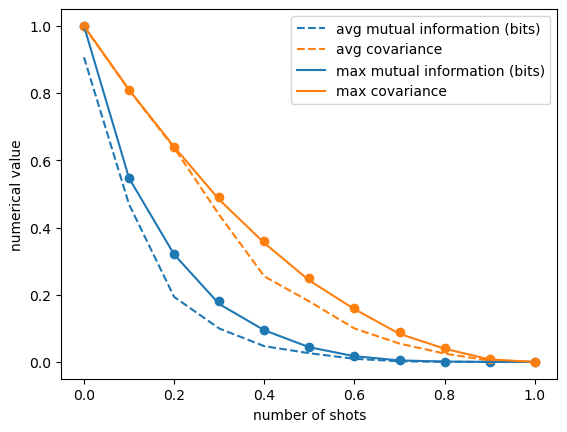

In [19]:
with open("../data/depolarizing_2023-03-29T21:45:41.957222.json", "r") as openfile:
    data = json.load(openfile)
    gamma = data["gamma"]
    char_mat_data = data["char_mat_data"]
    cov_mat_data = data["cov_mat_data"]

    plot_result(gamma, char_mat_data, cov_mat_data)
    plt.scatter(gamma, [depolarizing_mmi(gam) for gam in gamma])
    plt.scatter(gamma, [depolarizing_cov(gam) for gam in gamma])
    plt.legend()

### Amplitude Damping 

Applying qubit-wise amplitude-damping noise to $\rho_\Phi$ results in the state
\begin{align}
\mathcal E (\rho_\Phi) = \frac{1}{2} \begin{pmatrix} 1 + \gamma^2 & 0 & 0 & 1-\gamma \\ 0 & \gamma(1-\gamma) & 0 & 0 \\ 0 & 0 & \gamma(1-\gamma) & 0 \\ 1-\gamma & 0 & 0 & (1-\gamma)^2 \end{pmatrix}.
\end{align}
The optimal measurement is in the $X$-basis, which is equivalent to measuring the density matrix
\begin{align}
\frac{1}{4} \begin{pmatrix} 2-\gamma & \gamma & \gamma & 2\gamma^2 - 3\gamma + 2 \\ \gamma & \gamma & 2\gamma^2-\gamma & \gamma \\ \gamma & 2\gamma^2-\gamma & \gamma & \gamma \\ 2\gamma^2 - 3\gamma + 2 & \gamma & \gamma & 2 - \gamma \end{pmatrix} 
\end{align}
in the computational basis. This yields the measured mutual information 
\begin{align}
\frac{2-\gamma}{2} \log(2-\gamma) + \frac{\gamma}{2} \log \gamma
\end{align}
and covariance 
\begin{align}
1-\gamma
\end{align}

In [20]:
def amplitude_damping_prep_node(gam):
    def rot_bell_state(settings, wires):
        qnetvo.ghz_state(settings, wires)
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])
        qml.AmplitudeDamping(gam, wires=[wires[0]])
        qml.AmplitudeDamping(gam, wires=[wires[1]])

    bell_state_prep_node = qnetvo.PrepareNode(wires=[0, 1], ansatz_fn=rot_bell_state)
    return bell_state_prep_node

In [36]:
def amp_damp_mmi(gam):
    return (1 - gam / 2) * qnp.log2(2 - gam) + gam * my_log(gam) / 2


def amp_damp_cov(gam):
    return 1 - gam

In [22]:
gamma = [x / 10 for x in range(11)]
trial = 10

char_mat_data = [
    [
        characteristic_matrix_inference(
            amplitude_damping_prep_node(gam), num_steps=30, step_size=0.05
        )
        for t in range(trial)
    ]
    for gam in gamma
]
cov_mat_data = [
    [
        covariance_matrix_inference(amplitude_damping_prep_node(gam), num_steps=30, step_size=0.05)
        for t in range(trial)
    ]
    for gam in gamma
]

save_results(gamma, char_mat_data, cov_mat_data, "amp_damp")

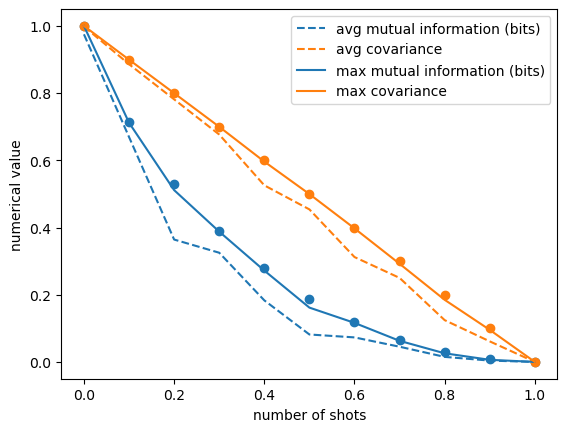

In [37]:
with open("../data/amp_damp_2023-03-29T21:54:55.498975.json", "r") as openfile:
    data = json.load(openfile)
    gamma = data["gamma"]
    char_mat_data = data["char_mat_data"]
    cov_mat_data = data["cov_mat_data"]

    plot_result(gamma, char_mat_data, cov_mat_data)
    plt.scatter(gamma, [amp_damp_mmi(gam) for gam in gamma])
    plt.scatter(gamma, [amp_damp_cov(gam) for gam in gamma])
    plt.legend()

### Phase Flip Channel 

A cool feature of this noise is that the local rotations after preparing the Bell state do matter!

In [148]:
def phase_flip_prep_node(gam):
    def rot_bell_state(settings, wires):
        qnetvo.ghz_state(settings, wires)
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])
        qml.PhaseFlip(gam, wires=[wires[0]])
        qml.PhaseFlip(gam, wires=[wires[1]])

    bell_state_prep_node = qnetvo.PrepareNode(wires=[0, 1], ansatz_fn=rot_bell_state)
    return bell_state_prep_node

In [149]:
def unrotated_phase_flip_prep_node(gam):
    def bell_state(settings, wires):
        qnetvo.ghz_state(settings, wires)
        qml.PhaseFlip(gam, wires=[wires[0]])
        qml.PhaseFlip(gam, wires=[wires[1]])

    bell_state_prep_node = qnetvo.PrepareNode(wires=[0, 1], ansatz_fn=bell_state)
    return bell_state_prep_node


def phase_flip_mmi(gam):
    mmi = qnetti.qubit_measured_mutual_infos_fn(
        unrotated_phase_flip_prep_node(gam), dev_kwargs={"name": "default.mixed"}
    )
    return mmi([0, 0, 0, 0, 0, 0])[0]


def phase_flip_cov(gam):
    cov_cost = qnetti.qubit_covariance_matrix_fn(
        unrotated_phase_flip_prep_node(gam), dev_kwargs={"name": "default.mixed"}
    )
    return abs(cov_cost([0, 0, 0, 0, 0, 0])[0, 1])

In [150]:
gamma = [x / 10 for x in range(11)]
trial = 30

vn_opt_kwargs = {"num_steps": 5, "step_size": 0.5}
mi_opt_kwargs = {"num_steps": 40, "step_size": 0.5}
cov_opt_kwargs = {"num_steps": 80, "step_size": 0.3}

char_mat_data = [
    [
        characteristic_matrix_inference(
            phase_flip_prep_node(gam),
            dev_kwargs={"name": "default.mixed"},
            vn_opt_kwargs=vn_opt_kwargs,
            mi_opt_kwargs=mi_opt_kwargs,
        )
        for t in range(trial)
    ]
    for gam in gamma
]

cov_mat_data = [
    [
        covariance_matrix_inference(
            phase_flip_prep_node(gam),
            dev_kwargs={"name": "default.mixed"},
            step_size=0.5,
            num_steps=40,
        )
        for t in range(trial)
    ]
    for gam in gamma
]

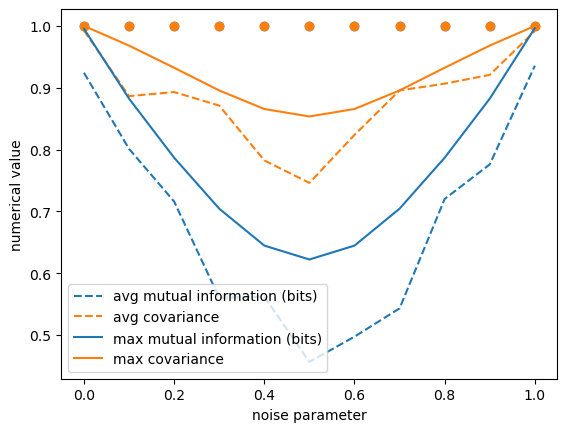

In [151]:
plt.plot(
    gamma,
    [reduce(lambda x, y: x + y, mat)[0, 1] / trial for mat in char_mat_data],
    label="avg mutual information (bits)",
    color="#1f77b4",
    linestyle="dashed",
)
plt.plot(
    gamma,
    [reduce(lambda x, y: qnp.abs(x) + qnp.abs(y), mat)[0, 1] / trial for mat in cov_mat_data],
    label="avg covariance",
    color="#ff7f0e",
    linestyle="dashed",
)
plt.plot(
    gamma,
    [reduce(lambda x, y: qnp.maximum(x, y), mat)[0, 1] for mat in char_mat_data],
    label="max mutual information (bits)",
    color="#1f77b4",
)
plt.plot(
    gamma,
    [reduce(lambda x, y: qnp.maximum(qnp.abs(x), qnp.abs(y)), mat)[0, 1] for mat in cov_mat_data],
    label="max covariance",
    color="#ff7f0e",
)
# the scatter plots takes measurement in Z basis
plt.scatter(gamma, [phase_flip_mmi(gam) for gam in gamma])
plt.scatter(gamma, [phase_flip_cov(gam) for gam in gamma])
plt.xlabel("noise parameter")
plt.ylabel("numerical value")
plt.legend()

## Conclusion 1:

It seems like under the presence of noise, the covariance method has a more difficult time reaching the optimum on average. Nonetheless, the optimal covariance is higher numerically than the measured mutual information, which would help distinguish zero versus nonzero correlation (which by our network assumptions implies entanglement and connectedness). 

Phase flip error seems to be distinct from depolarizing and amplitude damping noise. First, local rotations affect the result of the optimization. Second, covariance method seems to underperform on average despite having resulting in a higher value when the optimum is achieved. So, let's investigate a bit more. 

### 3-qubit W state with phase flip 

In [104]:
def phase_flip_prep_node(gam):
    def rot_w_state(settings, wires):
        qnetvo.W_state(settings, wires)
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])
        qml.ArbitraryUnitary([0.2, 3, -2.3], wires=[wires[2]])
        qml.PhaseFlip(gam, wires=[wires[0]])
        qml.PhaseFlip(gam, wires=[wires[1]])
        qml.PhaseFlip(gam, wires=[wires[2]])

    w_state_prep_node = qnetvo.PrepareNode(wires=[0, 1, 2], ansatz_fn=rot_w_state)
    return w_state_prep_node

In [105]:
gamma = [x / 10 for x in range(11)]
trial = 50

vn_opt_kwargs = {"num_steps": 5, "step_size": 0.5}
mi_opt_kwargs = {"num_steps": 40, "step_size": 0.5}
cov_opt_kwargs = {"num_steps": 40, "step_size": 0.5}

char_mat_data = [
    [
        characteristic_matrix_inference(
            phase_flip_prep_node(gam),
            dev_kwargs={"name": "default.mixed"},
            vn_opt_kwargs=vn_opt_kwargs,
            mi_opt_kwargs=mi_opt_kwargs,
        )
        for t in range(trial)
    ]
    for gam in gamma
]

cov_mat_data = [
    [
        covariance_matrix_inference(
            phase_flip_prep_node(gam),
            dev_kwargs={"name": "default.mixed"},
            qnode_kwargs=cov_opt_kwargs,
        )
        for t in range(trial)
    ]
    for gam in gamma
]

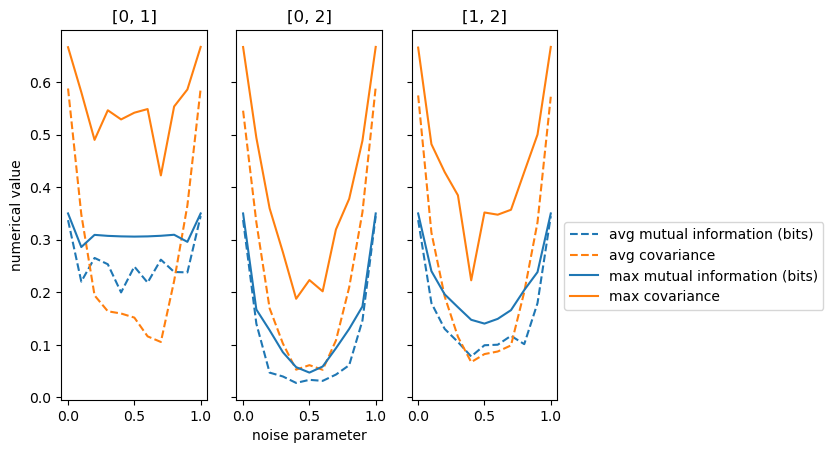

In [106]:
pairs = [[0, 1], [0, 2], [1, 2]]

fig, ax = plt.subplots(1, 3, sharey=True)

for idx, pair in enumerate(pairs):
    i = pair[0]
    j = pair[1]
    ax[idx].plot(
        gamma,
        [reduce(lambda x, y: x + y, mat)[i, j] / trial for mat in char_mat_data],
        label="avg mutual information (bits)",
        color="#1f77b4",
        linestyle="dashed",
    )
    ax[idx].plot(
        gamma,
        [reduce(lambda x, y: qnp.abs(x) + qnp.abs(y), mat)[i, j] / trial for mat in cov_mat_data],
        label="avg covariance",
        color="#ff7f0e",
        linestyle="dashed",
    )
    ax[idx].plot(
        gamma,
        [reduce(lambda x, y: qnp.maximum(x, y), mat)[i, j] for mat in char_mat_data],
        label="max mutual information (bits)",
        color="#1f77b4",
    )
    ax[idx].plot(
        gamma,
        [
            reduce(lambda x, y: qnp.maximum(qnp.abs(x), qnp.abs(y)), mat)[i, j]
            for mat in cov_mat_data
        ],
        label="max covariance",
        color="#ff7f0e",
    )
    ax[idx].set_title(pair)

ax[1].set_xlabel("noise parameter")
ax[0].set_ylabel("numerical value")

ax[2].legend(bbox_to_anchor=(1, 0.0, 0.5, 0.5))

### 3-qubit arbitrary entanglement with phase flip 

In [112]:
qnp.random.seed(100)
param = qnp.random.uniform(size=(63,))


def no_noise_prep_node(gam):
    def random_state(settings, wires):
        qml.ArbitraryUnitary(param, wires)

    random_state_prep_node = qnetvo.PrepareNode(wires=[0, 1, 2], ansatz_fn=random_state)
    return random_state_prep_node


def phase_flip_prep_node(gam):
    def random_state(settings, wires):
        qml.ArbitraryUnitary(param, wires)
        qml.PhaseFlip(gam, wires=[wires[0]])
        qml.PhaseFlip(gam, wires=[wires[1]])
        qml.PhaseFlip(gam, wires=[wires[2]])

    random_state_prep_node = qnetvo.PrepareNode(wires=[0, 1, 2], ansatz_fn=random_state)
    return random_state_prep_node

In [117]:
gamma = [x / 10 for x in range(11)]
trial = 30

vn_opt_kwargs = {"num_steps": 5, "step_size": 0.5}
mi_opt_kwargs = {"num_steps": 40, "step_size": 0.5}
cov_opt_kwargs = {"num_steps": 40, "step_size": 0.5}

char_mat_noisy = [
    [
        characteristic_matrix_inference(
            phase_flip_prep_node(gam),
            dev_kwargs={"name": "default.mixed"},
            vn_opt_kwargs=vn_opt_kwargs,
            mi_opt_kwargs=mi_opt_kwargs,
        )
        for t in range(trial)
    ]
    for gam in gamma
]

cov_mat_noisy = [
    [
        covariance_matrix_inference(
            phase_flip_prep_node(gam),
            dev_kwargs={"name": "default.mixed"},
            qnode_kwargs=cov_opt_kwargs,
        )
        for t in range(trial)
    ]
    for gam in gamma
]

char_mat_exact = [
    [
        characteristic_matrix_inference(
            no_noise_prep_node(gam), vn_opt_kwargs=vn_opt_kwargs, mi_opt_kwargs=mi_opt_kwargs
        )
        for t in range(trial)
    ]
    for gam in gamma
]

cov_mat_exact = [
    [
        covariance_matrix_inference(no_noise_prep_node(gam), qnode_kwargs=cov_opt_kwargs)
        for t in range(trial)
    ]
    for gam in gamma
]

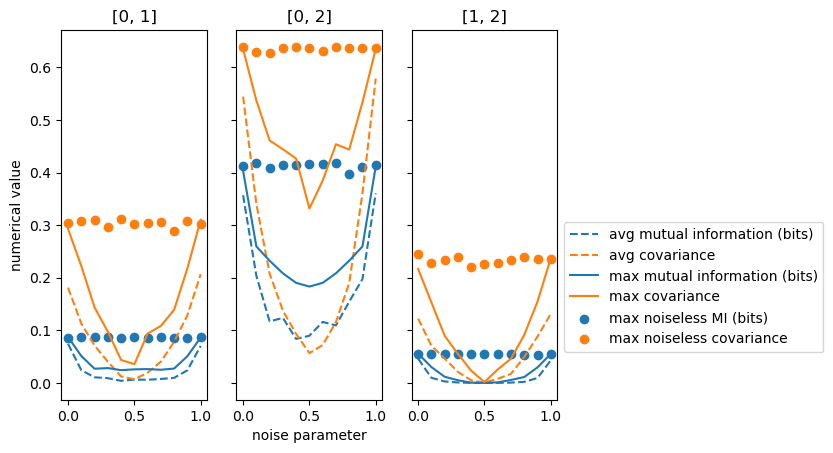

In [118]:
pairs = [[0, 1], [0, 2], [1, 2]]

fig, ax = plt.subplots(1, 3, sharey=True)

for idx, pair in enumerate(pairs):
    i = pair[0]
    j = pair[1]
    ax[idx].plot(
        gamma,
        [reduce(lambda x, y: x + y, mat)[i, j] / trial for mat in char_mat_noisy],
        label="avg mutual information (bits)",
        color="#1f77b4",
        linestyle="dashed",
    )
    ax[idx].plot(
        gamma,
        [reduce(lambda x, y: qnp.abs(x) + qnp.abs(y), mat)[i, j] / trial for mat in cov_mat_noisy],
        label="avg covariance",
        color="#ff7f0e",
        linestyle="dashed",
    )
    ax[idx].plot(
        gamma,
        [reduce(lambda x, y: qnp.maximum(x, y), mat)[i, j] for mat in char_mat_noisy],
        label="max mutual information (bits)",
        color="#1f77b4",
    )
    ax[idx].plot(
        gamma,
        [
            reduce(lambda x, y: qnp.maximum(qnp.abs(x), qnp.abs(y)), mat)[i, j]
            for mat in cov_mat_noisy
        ],
        label="max covariance",
        color="#ff7f0e",
    )
    ax[idx].scatter(
        gamma,
        [reduce(lambda x, y: qnp.maximum(x, y), mat)[i, j] for mat in char_mat_exact],
        label="max noiseless MI (bits)",
        color="#1f77b4",
    )
    ax[idx].scatter(
        gamma,
        [
            reduce(lambda x, y: qnp.maximum(qnp.abs(x), qnp.abs(y)), mat)[i, j]
            for mat in cov_mat_exact
        ],
        label="max noiseless covariance",
        color="#ff7f0e",
    )
    ax[idx].set_title(pair)

ax[1].set_xlabel("noise parameter")
ax[0].set_ylabel("numerical value")

ax[2].legend(bbox_to_anchor=(1, 0.0, 0.5, 0.5))

## Conclusion 2: 

It seems like this (lower average performance for covariance method) occurs quite universally, not restricted to GHZs (though the most obvious in the GHZ case). Can we find out why? 

In [128]:
def characteristic_matrix_inference(prep_node, **kwargs):
    char_mat, mi_opt_dict, vn_opt_dict = qnetti.optimize_characteristic_matrix(prep_node, **kwargs)
    return char_mat


def covariance_matrix_inference(
    prep_node,
    **kwargs,
):
    cov_mat, opt_dict = qnetti.optimize_covariance_matrix(prep_node, **kwargs)
    return cov_mat


def phase_flip_prep_node(gam):
    def rot_bell_state(settings, wires):
        qnetvo.ghz_state(settings, wires)
        qml.ArbitraryUnitary([qnp.pi / 4, 0.3, -1.5], wires=[wires[0]])
        qml.ArbitraryUnitary([-0.7, 2.9, 1.2], wires=[wires[1]])
        qml.PhaseFlip(gam, wires=[wires[0]])
        qml.PhaseFlip(gam, wires=[wires[1]])

    bell_state_prep_node = qnetvo.PrepareNode(wires=[0, 1], ansatz_fn=rot_bell_state)
    return bell_state_prep_node

In [147]:
cov_opt_kwargs = {"num_steps": 200, "step_size": 0.3}
cov_mat, opt_dict = qnetti.optimize_covariance_matrix(
    phase_flip_prep_node(0.5), dev_kwargs={"name": "default.mixed"}, qnode_kwargs=cov_opt_kwargs
)

print(len(opt_dict["cost_vals"]))

11


In [ ]:
gamma = [x / 10 for x in range(11)]
trial = 30

vn_opt_kwargs = {"num_steps": 5, "step_size": 0.5}
mi_opt_kwargs = {"num_steps": 40, "step_size": 0.5}
cov_opt_kwargs = {"num_steps": 80, "step_size": 0.3}

char_mat_data = [
    [
        characteristic_matrix_inference(
            phase_flip_prep_node(gam),
            dev_kwargs={"name": "default.mixed"},
            vn_opt_kwargs=vn_opt_kwargs,
            mi_opt_kwargs=mi_opt_kwargs,
        )
        for t in range(trial)
    ]
    for gam in gamma
]

cov_mat_data = [
    [
        covariance_matrix_inference(
            phase_flip_prep_node(gam),
            dev_kwargs={"name": "default.mixed"},
            qnode_kwargs=cov_opt_kwargs,
        )
        for t in range(trial)
    ]
    for gam in gamma
]